# Tutorial on using the Platform

This guide will show you how to use the platform and provide a detailed breakdown of how it works.

## Initialization

First we need to import the necessary class

In [1]:
from qEmQUIP import QEM, conf
import sys, glob, os
from commons import convert_to_json, triq_optimization, qiskit_optimization, \
    calibration_type_enum, qiskit_compilation_enum, normalize_counts, calculate_success_rate_tvd, \
    convert_dict_binary_to_int, convert_dict_int_to_binary, sum_last_n_digits_dict
import wrappers.qiskit_wrapper as qiskit_wrapper
from wrappers.qiskit_wrapper import QiskitCircuit
import pandas as pd
import mthree
import mapomatic as mm
import mthree
from qiskit_aer import AerSimulator, QasmSimulator, Aer
from qiskit.qasm2 import dumps
import matplotlib.pyplot as plt

CB_color_cycle = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#D62728', '#FF9896',
                  '#9467BD', '#C5B0D5', '#8C564B', '#C49C94', '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7',
                  '#BCBD22', '#DBDB8D', '#17BECF', '#9EDAE5'
                  ]

markers = ['o', 'v', '^', 's', '+', '*', 'x', 'd', '<', '>', 'p']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']



Here we need to initialize the object, please check the `config.ini` file to update the general config

In [2]:
# Put your Qiskit Token
token = "74076e69ed0d571c8e0ff8c0b2c912c28681d47426cf16a5d817825de16f7dbd95bf6ff7c604b706803b78b2e21d1dd5cacf9f1b0aa81d672d938bded8049a17"
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)

Time for setup the backends: 12.346156000999997 seconds


## Quick Run

### Send to real backend

In [3]:
# prepare the circuit
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()
shots = 10000

# select compilation techniques
# compilations = ["qiskit_0", "qiskit_3", "triq_lcd_sabre"]
compilations = ["qiskit_0", "qiskit_3"]

In [4]:
#q.send_to_real_backend(qasm_files, compilations)

### Send to simulator

In [5]:
noise_levels = [0.6, 0.8, 1.0]
df = q.run_simulator(qasm_files, compilations, noise_levels, shots, send_to_db=True)
df

Time for running the init header: 0.0010187079999468551 seconds
Total send to local simulator : 1
Running to Local Simulator with batch id: 11 ... 
Sent!
Time for sending to local simulator: 0.0019489439999915703 seconds


,circuit_name,compilation,noise_level,success_rate
0,bv_6,qiskit_0,0.6,0.7918
1,bv_6,qiskit_3,0.6,0.0621
2,bv_6,qiskit_0,0.8,0.7637
3,bv_6,qiskit_3,0.8,0.0461
4,bv_6,qiskit_0,1.0,0.6630
5,bv_6,qiskit_3,1.0,0.7903


### Update the configs from the collected calibration data

To update the fake backend calibration data

In [6]:
# q.update_hardware_configs()

In [7]:
# qiskit_wrapper.generate_new_props(q.backend, "avg")
# qiskit_wrapper.generate_new_props(q.backend, "mix")
# qiskit_wrapper.generate_new_props(q.backend, "recent_15_adjust")

# Detailed breakdown

## Prepare the circuits

You can get the quantum circuit from a folder contains the qasm files or qasm string

In [8]:
# The path is coming from the config file, but you can also modify it here
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()
print(qasm_files)

['./circuits/testing/bv_6.qasm']


Get the circuits from file

In [9]:
qc = q.get_circuit_properties(qasm_source=qasm_files[0])
qc.circuit.draw(idle_wires=False)

┌─────────────┐                    ┌─────────────┐               ┌─┐»
q_0: ┤ U3(π/2,0,π) ├─────────────────■──┤ U3(π/2,0,π) ├───────────────┤M├»
     ├─────────────┤                 │  └─────────────┘┌─────────────┐└╥┘»
q_1: ┤ U3(π/2,0,π) ├─────────────────┼─────────■───────┤ U3(π/2,0,π) ├─╫─»
     ├─────────────┤                 │         │       └─────────────┘ ║ »
q_2: ┤ U3(π/2,0,π) ├─────────────────┼─────────┼──────────────■────────╫─»
     ├─────────────┤                 │         │              │        ║ »
q_3: ┤ U3(π/2,0,π) ├─────────────────┼─────────┼──────────────┼────────╫─»
     ├─────────────┤                 │         │              │        ║ »
q_4: ┤ U3(π/2,0,π) ├─────────────────┼─────────┼──────────────┼────────╫─»
     └┬───────────┬┘┌─────────────┐┌─┴─┐     ┌─┴─┐          ┌─┴─┐      ║ »
q_5: ─┤ U3(π,0,π) ├─┤ U3(π/2,0,π) ├┤ X ├─────┤ X ├──────────┤ X ├──────╫─»
      └───────────┘ └─────────────┘└───┘     └───┘          └───┘      ║ »
c: 6/══════════════════════════════════════════════════════════════════╩═»
                                                                       0 »
«                                                                 
«q_0: ────────────────────────────────────────────────────────────
«                    ┌─┐                                          
«q_1: ───────────────┤M├──────────────────────────────────────────
«     ┌─────────────┐└╥┘               ┌─┐                        
«q_2: ┤ U3(π/2,0,π) ├─╫────────────────┤M├────────────────────────
«     └─────────────┘ ║ ┌─────────────┐└╥┘               ┌─┐      
«q_3: ───────■────────╫─┤ U3(π/2,0,π) ├─╫────────────────┤M├──────
«            │        ║ └─────────────┘ ║ ┌─────────────┐└╥┘┌─┐   
«q_4: ───────┼────────╫────────■────────╫─┤ U3(π/2,0,π) ├─╫─┤M├───
«          ┌─┴─┐      ║      ┌─┴─┐      ║ ├─────────────┤ ║ └╥┘┌─┐
«q_5: ─────┤ X ├──────╫──────┤ X ├──────╫─┤ U3(π/2,0,π) ├─╫──╫─┤M├
«          └───┘      ║      └───┘      ║ └─────────────┘ ║  ║ └╥┘
«c: 6/════════════════╩═════════════════╩═════════════════╩══╩══╩═
«                     1                 2                 3  4  5

Or you can also get it from the qasm strings

In [10]:
qasm_text = """OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0], q[1];
barrier q[0], q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
"""

qc = q.get_circuit_properties(qasm_source=qasm_text)
qc.circuit.draw(idle_wires=False)

┌─────────────┐      ░ ┌─┐   
q_0: ┤ U3(π/2,0,π) ├──■───░─┤M├───
     └─────────────┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ───────────────┤ X ├─░──╫─┤M├
                    └───┘ ░  ║ └╥┘
c: 2/════════════════════════╩══╩═
                             0  1

`q.get_circuit_properties` will give an object of `QiskitCircuit` which will give the information of the circuits: 
- `circuit`: `QuantumCircuit` object from Qiskit
- `depth`: circuit depth
- `gates`: number of gates used in the circuit
- `total_gates`: number of total gates used in the circuit
- `correct_output`: noiseless output from the simulation
- `qasm`: OpenQASM2 file from the circuit translated to `U3` and `cx` gates
- `qasm_original`: OpenQASM2 file from the circuit original


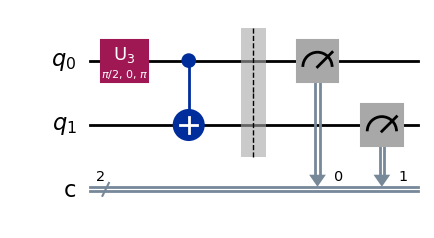

In [11]:
qc.circuit.draw("mpl")

In [12]:
print("Number of depth:", qc.depth)
print("Number of gates:", qc.gates)
print("Number of total gates:", qc.total_gate) 
print("Noiseless simulation output:", qc.correct_output)
print("Circuit Qasm:", qc.qasm)

Number of depth: 3
Number of gates: {'measure': 2, 'u3': 1, 'cx': 1, 'barrier': 1}
Number of total gates: 3
Noiseless simulation output: {'3': 0.492, '0': 0.508}
Circuit Qasm: OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u3(pi/2,0,pi) q[0];
cx q[0],q[1];
barrier q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


## Compilation Techniques

### Qiskit

We integrated several compilation techniques from Qiskit

In [13]:
print("Existing Qiskit Compilation Options:")
for member in qiskit_compilation_enum:
    print(member.name)

Existing Qiskit Compilation Options:
qiskit_0
qiskit_3
qiskit_NA_avg
qiskit_NA_lcd
qiskit_NA_mix
qiskit_NA_w15
qiskit_NA_avg_adj
qiskit_NA_lcd_adj
qiskit_NA_mix_adj
qiskit_NA_w15_adj
qiskit_NA_wn
qiskit_NA_wn_adj
mapomatic_lcd
mapomatic_avg
mapomatic_mix
mapomatic_avg_adj
mapomatic_w15_adj


In [14]:
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name=qiskit_compilation_enum.qiskit_3.value)
print(updated_qasm)
print(initial_mapping)

OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }
gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
qreg q[127];
creg c[2];
rz(-pi/2) q[104];
sx q[104];
rz(-2.3419111674042767) q[104];
sx q[104];
rz(-pi/2) q[104];
rz(-pi/2) q[111];
sx q[111];
rz(2.4599343627715466) q[111];
ecr q[111],q[104];
rz(pi/2) q[104];
sx q[104];
rz(-2.3419111674042785) q[104];
rz(-2.252454617613143) q[111];
sx q[111];
rz(pi/2) q[111];
barrier q[104],q[111];
measure q[104] -> c[0];
measure q[111] -> c[1];
[104, 111]


### TriQ

Also, we integrate TriQ Compilation with different options.

Qubit placement options:
- `na`: initial mapping from Noise-adaptive technique []
- `mapo`: initial mapping from Mapomatic technique []
- `sabre`: initial mapping from SABRE []

Calibration type options:
- `lcd` : TriQ's routing with last calibration data.
- `avg` : TriQ's routing with average calibration data.
- `mix` : TriQ's routing with mix calibration data. (Mix = if the qubits calibrated today, we will use the last calibration data for that qubit, otherwise we will use the average)
- `w15` : TriQ's routing with average calibration data of 15 days from the qubit is compiled.

The combinations of name become: `triq_<calibration_type>_<layout>`. For examples:
- `triq_avg_na`
- `triq_mix_sabre`

**Note: From Qiskit version > 1.0.0, `noise_adaptive` layout has been removed**

In [15]:
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="triq_avg_sabre")
print(updated_qasm)

print(initial_mapping)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[127];
creg c[127];
u2(0,3.14159265358979) q[123];
cx q[123],q[122];
measure q[123] -> c[0];
measure q[122] -> c[1];

[123, 122]


## Initiate Noisy simulator

To play around with the noise, we can get retrieve the last recorded calibration data from IBM's backend, and scale down the error


In [16]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

## Running the compiled circuit to the simulator

First, we need to transpile the circuit to the targeted backend

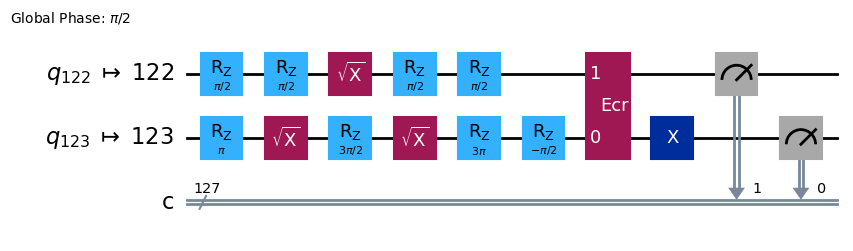

In [17]:
qc = QiskitCircuit(updated_qasm)
circuit = qc.transpile_to_target_backend(q.backend)
circuit.draw("mpl", idle_wires=False, fold=60)

In [18]:
shots = 10000
job = noisy_simulator.run(circuit, shots=shots)
result = job.result()  
output = result.get_counts()
output_normalize = normalize_counts(output, shots=shots)
shortened_output = sum_last_n_digits_dict(output, len(initial_mapping))
shortened_output

{'01': 55, '11': 4957, '10': 55, '00': 4933}

## Calculate the Fidelity

In [19]:
fidelity = calculate_success_rate_tvd(qc.correct_output,output_normalize)
fidelity

0.9888

## Error Mitigation (Mthree)

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService
qiskit_token = token

QiskitRuntimeService.save_account(channel="ibm_quantum", token=qiskit_token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=qiskit_token)
backend_service = service.backend("ibm_sherbrooke")
backend_sim = AerSimulator.from_backend(backend_service)

In [22]:
#probs_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output, shots)
probs_m3 = q.apply_mthree(backend_sim, initial_mapping, output, shots)
fidelity_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
overhead = (fidelity_m3 - fidelity) / fidelity_m3
print(fidelity, fidelity_m3, overhead)

0.9888 0.9929503665877876 0.004179832877296813


## Dynamical Decoupling

In [25]:
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import InstructionProperties
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit import transpile
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, ASAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer

def add_y_gate_properties(backend):
    target = backend.target
    
    # add Y gate properties
    y_gate_properties = {}
    for qubit in range(target.num_qubits):
        y_gate_properties.update(
            {
                (qubit,): InstructionProperties(
                    duration=target["x"][(qubit,)].duration,
                    error=target["x"][(qubit,)].error,
                )
            }
        )
    target.add_instruction(YGate(), y_gate_properties)

def apply_dd(circuit, backend, sequence_type = "XX", scheduling_method = "alap"):

    X = XGate()
    Y = YGate()
    
    if sequence_type == "XX":
        dd_sequence = [X, X]
    elif sequence_type == "XpXm":
        dd_sequence = [X, X]
    elif sequence_type == "XY4":
        dd_sequence = [X, Y, X, Y]

    target = backend.target

    # Set the scheduling method
    if scheduling_method == "alap":
        scheduling = ALAPScheduleAnalysis(target=target)
    elif scheduling_method == "asap":
        scheduling = ASAPScheduleAnalysis(target=target)

    dd_pm = PassManager(
    [
        scheduling,
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
    )
    
    circuit_dd = dd_pm.run(circuit)

    return circuit_dd

# Put all of them together

In [29]:
res_circuit_name = []
res_compilations = []
res_noise_levels = []
res_success_rate = []
res_success_rate_dd = []
res_success_rate_m3 = []
res_success_rate_dd_m3 = []

# prepare the circuit
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()

shots = 10000

# select compilation techniques
compilations = ["qiskit_0", "qiskit_3", "triq_lcd_sabre"]
# compilations = ["qiskit_0", "qiskit_3"]

# select the noise levels (0 = noiseless, 1 = noise model from real backend)
noise_levels = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
# noise_levels = [1.0]


for qasm in qasm_files:
    qc = q.get_circuit_properties(qasm_source=qasm)
    circuit_name = qasm.split("/")[-1].split(".")[0]

    for comp in compilations:    
        updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name=comp)
        compiled_qc = QiskitCircuit(updated_qasm)
        circuit = compiled_qc.transpile_to_target_backend(q.backend)

        print("Circuit : ", circuit_name, ", Compilation : ", comp)
        
        for noise in noise_levels:
            
            noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, noise)
            
            job = noisy_simulator.run(circuit, shots=shots)
            result = job.result()  
            output = result.get_counts()
            output_normalize = normalize_counts(output, shots=shots)

            tvd = calculate_success_rate_tvd(qc.correct_output,output_normalize)

            probs_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output, shots)
            tvd_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
            
            circuit_dd = apply_dd(circuit, noisy_simulator)
            job_dd = noisy_simulator.run(circuit_dd, shots=shots)
            result_dd = job_dd.result()  
            output_dd = result.get_counts()
            output_normalize_dd = normalize_counts(output_dd, shots=shots)

            tvd_dd = calculate_success_rate_tvd(qc.correct_output,output_normalize)

            probs_dd_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output_dd, shots)
            tvd_dd_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
            
            
            print("Noise level :", noise, "- sr :", np.round(tvd,4), ", sr m3:", np.round(tvd_m3,4),
                  ", sr dd :", np.round(tvd_dd,4), ", sr dd m3:", np.round(tvd_dd_m3,4))
            res_circuit_name.append(circuit_name)
            res_compilations.append(comp)
            res_noise_levels.append(noise)
            res_success_rate.append(tvd)
            res_success_rate_m3.append(tvd_m3)
            res_success_rate_dd.append(tvd_dd)
            res_success_rate_dd_m3.append(tvd_dd_m3)

        


Circuit :  bv_6 , Compilation :  qiskit_0
Noise level : 0.0 - sr : 1.0 , sr m3: 1.0 , sr dd : 1.0 , sr dd m3: 1.0
Noise level : 0.1 - sr : 0.8457 , sr m3: 0.8949 , sr dd : 0.8457 , sr dd m3: 0.8949
Noise level : 0.2 - sr : 0.6923 , sr m3: 0.7748 , sr dd : 0.6923 , sr dd m3: 0.7748
Noise level : 0.4 - sr : 0.4598 , sr m3: 0.5749 , sr dd : 0.4598 , sr dd m3: 0.5749
Noise level : 0.6 - sr : 0.2716 , sr m3: 0.39 , sr dd : 0.2716 , sr dd m3: 0.39
Noise level : 0.8 - sr : 0.1235 , sr m3: 0.1926 , sr dd : 0.1235 , sr dd m3: 0.1926
Noise level : 1.0 - sr : 0.1015 , sr m3: 0.1828 , sr dd : 0.1015 , sr dd m3: 0.1828
Circuit :  bv_6 , Compilation :  qiskit_3
Noise level : 0.0 - sr : 1.0 , sr m3: 1.0 , sr dd : 1.0 , sr dd m3: 1.0
Noise level : 0.1 - sr : 0.5728 , sr m3: 0.5847 , sr dd : 0.5728 , sr dd m3: 0.5847
Noise level : 0.2 - sr : 0.3381 , sr m3: 0.352 , sr dd : 0.3381 , sr dd m3: 0.352
Noise level : 0.4 - sr : 0.1341 , sr m3: 0.1451 , sr dd : 0.1341 , sr dd m3: 0.1451
Noise level : 0.6 - sr

## Plot the results

In [30]:
df = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate,
    })

df_m3 = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate_m3
    })

### Combined plot

In [31]:
def create_line_chart_combined(data, y, opt_values, metric, ax, type, ylabel, xlabel, yticks = None, 
                      y_bot = None, y_top = None, figsize = (12,8), c_idx = 0, reindex = None, x_index = "header_id", x_labels = [], i=0):
    tmp = ()
    
    for idx, opt in enumerate(opt_values):
        # print(idx, opt)
        idx_marker = idx + (len(opt_values) * i)
        # idx = idx 
        pivot = pd.pivot_table(data[data[y] == opt], 
                               values=[metric], 
                               index=x_index, 
                               columns=y, 
                               aggfunc='mean')    
        if reindex != 0:
            if reindex is None:
                if len(tmp) == 0:
                    tmp = pivot.index
                else:
                    pivot = pivot.reindex(tmp)
            else:
                pivot = pivot.reindex(reindex)

        idx_color = (idx % (len(markers)))
        # print(idx_color, idx, len(markers))

        # print (pivot)
         
        pivot.plot(kind='line', color=CB_color_cycle[idx], marker=markers[idx_marker], linestyle=linestyles[i], figsize=figsize, ax=ax)

        mean= pivot.mean().mean()

    if i == 1:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
    
        if yticks is not None:
            ax.set_yticks(yticks)
    
        if y_bot is not None and y_top is not None:
            ax.set_ylim(bottom= y_bot, top= y_top)
    
        if x_labels is not None:
            ax.set_xticks(np.arange(len(x_labels)))
            ax.set_xticklabels(x_labels)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
        ax.grid()


In [37]:
def show_figure_by_opt_combined(dfs, y, y_values, metric, ylabel, xlabel, legend = None, figsize=(10,6), reindex=None, 
                             x_index = "total_2q", x_labels = [], x_lim = [1, 100], 
                            y_lim = [0,1], title=None, legend_position=None, circuit_name = "", hw_name = ""):
    # y_values = noise_levels

    metrics = [metric]
    row = 1
    col = 1

    fig, ax = plt.subplots(nrows=row, ncols=1)

    yticks = None
    
    for i in range(len(dfs)):
        # print(i)
        create_line_chart_combined(dfs[i], y, y_values, metrics[0], ax, "opt", ylabel, xlabel, yticks, figsize=figsize, reindex=reindex,
                          x_index = x_index, x_labels=x_labels, i=i)

    # n=[]        
    # n.append(ax.axhline(np.NaN, color="gray", linestyle='-.'))

    # l1 = ax.legend(n, ["Mean"], loc=[0.82, 0.49])

    if legend is None:
            l2 = plt.legend()
    else:
        if legend_position == None:
            l2 = plt.legend(legends)
        else:
            l2 = plt.legend(legends, loc = legend_position)
    
    # plt.tight_layout()
    # ax.add_artist(l1)
    plt.xlim(x_lim) 
    plt.ylim(y_lim)
    plt.title(title)
    #plt.savefig("./output/{}_{}_{}.png".format(circuit_name, hw_name, x_index), dpi=500, bbox_inches='tight')
    plt.show()
    
    return plt

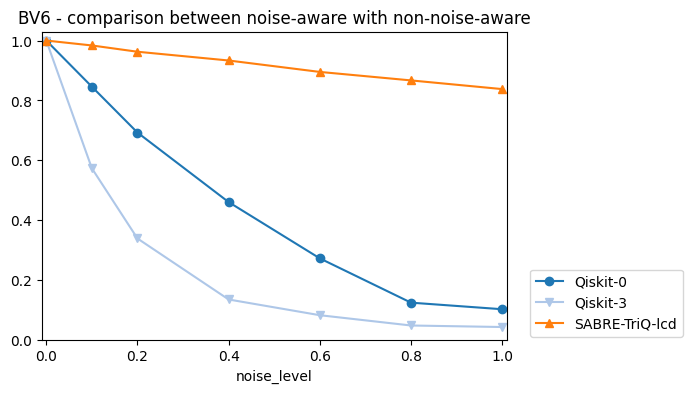

In [39]:
y_values = ['qiskit_0', 'qiskit_3', "triq_lcd_sabre"]
legends  = ["Qiskit-0", "Qiskit-3", "SABRE-TriQ-lcd",
            "Qiskit-0 (M3)", "Qiskit-3 (M3)", "SABRE-TriQ-lcd (M3)"
           ]
x_lim=[-0.01, 1.01]
y_lim=[0,1.03]
legend_position=(0.01,0.01)
circuit_name = "adder"
hw_name = "sherbrooke"
title="BV6 - comparison between noise-aware with non-noise-aware"
x_index = "noise_level"

# print(y_values)
x_labels = None
dfs = [df]

plt = show_figure_by_opt_combined(dfs, "compilation", y_values, "success_rate", "Success Rate", "Physical error rate scaling factor (ibm_sherbrooke)", legends, figsize=(6,4), 
                   reindex=None, x_index = "noise_level", x_labels=x_labels, x_lim=[-0.01, 1.01], y_lim=[0,1.03],legend_position=(1.05,0.01),
                       circuit_name = "polar_n2_x", hw_name = hw_name, title=title)

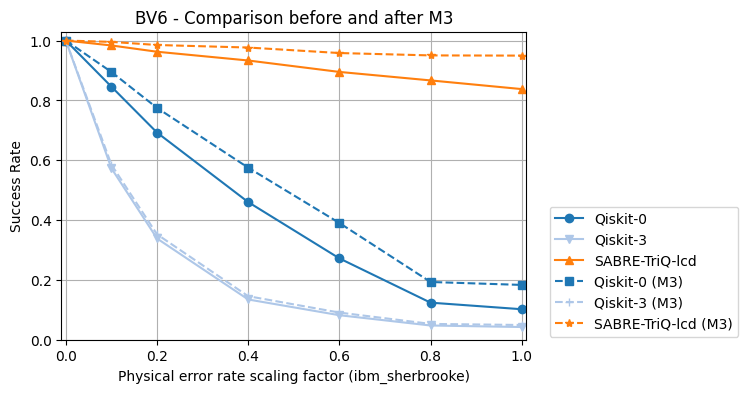

In [34]:
y_values = ['qiskit_0', 'qiskit_3', "triq_lcd_sabre"]
legends  = ["Qiskit-0", "Qiskit-3", "SABRE-TriQ-lcd",
            "Qiskit-0 (M3)", "Qiskit-3 (M3)", "SABRE-TriQ-lcd (M3)"
           ]
x_lim=[-0.01, 1.01]
y_lim=[0,1.03]
legend_position=(0.01,0.01)
circuit_name = "adder"
hw_name = "sherbrooke"
title="BV6 - comparison before and after M3"
x_index = "noise_level"

# print(y_values)
x_labels = None
dfs = [df, df_m3]

plt = show_figure_by_opt_combined(dfs, "compilation", y_values, "success_rate", "Success Rate", "Physical error rate scaling factor (ibm_sherbrooke)", legends, figsize=(6,4), 
                   reindex=None, x_index = "noise_level", x_labels=x_labels, x_lim=[-0.01, 1.01], y_lim=[0,1.03],legend_position=(1.05,0.01),
                       circuit_name = "polar_n2_x", hw_name = hw_name, title=title)

# Estimator

In [19]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

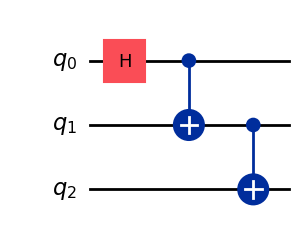

In [20]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.draw("mpl")

In [21]:
ZZ = SparsePauliOp('ZZZ')
ZI = SparsePauliOp('ZII')
IX = SparsePauliOp('IXI')
IZ = SparsePauliOp('IZI')
XI = SparsePauliOp('XII')
XX = SparsePauliOp('XXX')
observables = [IZ, IX, ZI, XI, ZZ, XX]

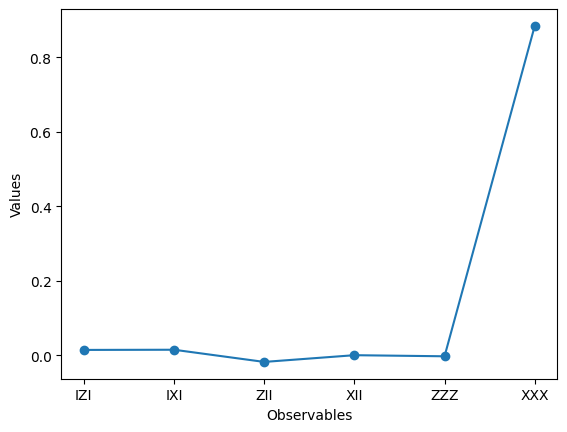

In [22]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)
estimator = Estimator(mode=noisy_simulator)
pub = (qc, observables)
job = estimator.run(pubs=[pub])
# Collect the data
data = ['IZI', 'IXI', 'ZII', 'XII', 'ZZZ', 'XXX']
values = job.result()[0].data.evs

# Set up our graph
container = plt.plot(data, values, '-o')

# Label each axis
plt.xlabel('Observables')
plt.ylabel('Values')

# Draw the final graph
plt.show()

In [45]:
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.circuit.library import EfficientSU2

pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
print(pauli_op.to_matrix())

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


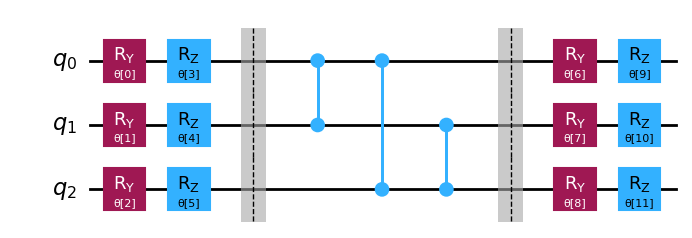

In [46]:
num_qubits = 3 #Add your code here
rotation_blocks = ["ry","rz"] #Add your code here
entanglement_blocks = "cz" #Add your code here
entanglement = "full" #Add your code here

ansatz = TwoLocal(num_qubits, ['ry','rz'], 'cz', 'full', reps=1, insert_barriers=True) #Add your code here

### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

In [47]:
num_params = ansatz.num_parameters
backend_answer = noisy_simulator #Add your code
optimization_level_answer = 3 #Add your code
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz) # Add your code
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

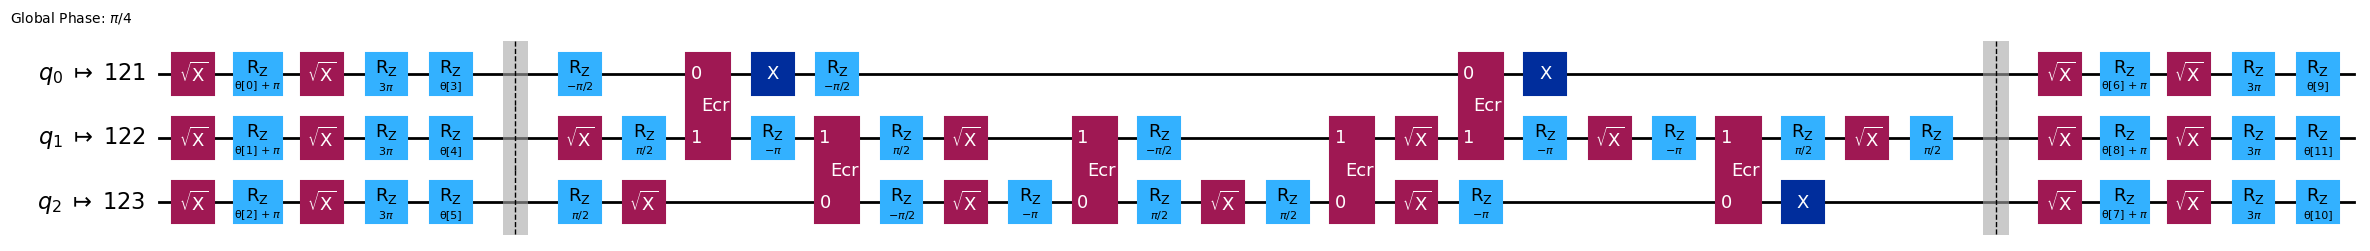

In [48]:
isa_circuit.draw('mpl', idle_wires=False, fold=50)

In [49]:
initial_mapping = qiskit_wrapper.get_initial_layout_from_circuit(isa_circuit)
initial_mapping

[121, 122, 123]

### Mthree

In [50]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

x0 = 2 * np.pi * np.random.random(num_params)
bound_circs = isa_circuit.assign_parameters(x0)
creg = ClassicalRegister(3, 'c')
bound_circs.add_register(creg)
bound_circs.measure(40, 0)
bound_circs.measure(39, 1)
bound_circs.measure(38, 2)
result = noisy_simulator.run(bound_circs, shots=10000).result()
counts = result.get_counts()

mit = mthree.M3Mitigation(noisy_simulator)
mit.cals_from_system(initial_mapping)

quasis = mit.apply_correction(counts, initial_mapping)

coeffs = []
meas_strings = []

for i in pauli_op.to_list():
    meas_string, coeff = i
    coeffs.append(coeff)
    meas_strings.append(meas_string)

print(meas_strings, coeffs)
print(np.sum(coeffs * quasis.expval(meas_strings)))


['ZII', 'IZI', 'IIZ'] [(1+0j), (1+0j), (1+0j)]
(2.979487888014451+0j)


## Classical Optimizer

In [51]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params]) #Add your code
    result = estimator.run(pubs=[pub]).result() #Add your code
    energy = result[0].data.evs[0] #Add your code

    callback_dict["iters"] += 1 #Add your code
    callback_dict["prev_vector"] = params #Add your code
    callback_dict["cost_history"].append(energy) #Add your code


### Don't change any code past this line ###
    print(energy)
    return energy, result

In [52]:
ansatz = EfficientSU2(3)
params = np.ones((1,ansatz.num_parameters))
aer_sim = noisy_simulator
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuits = pm.run(ansatz)
choc_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
hamiltonian_isa = choc_op.apply_layout(layout=isa_circuits.layout)
estimator = Estimator(mode=aer_sim)

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
}
cost, result = cost_func(
    params,
    isa_circuits,
    hamiltonian_isa,
    estimator,
    callback_dict
)

[0.65234375]


In [53]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [54]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([5.79824777, 5.09820151, 3.27697403, 4.97633294, 1.67698176,
       2.34188422, 6.22464397, 3.97942121, 3.04831473, 0.66792792,
       0.64596321, 5.92312659])

In [55]:
# backend = FakeSherbrooke()
backend = noisy_simulator

# ### Don't change any code past this line ###

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 10})

1.4873046875
1.52294921875
1.13525390625
0.60205078125
0.61767578125
0.5361328125
0.513671875
0.1201171875
1.00634765625
0.6005859375


In [ ]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()

## Error Mitigation

 More detais about how to configure error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).


When using the Estimator primitive, we can use the ```EstimatorOptions()``` object to set the options for error mitigation and error suppression techniques. This table shows the most used ones:

| Options              | Sub-options              | Sub-sub-options         | Choices                                                                                   | Default                   |
|----------------------|--------------------------|-------------------------|-------------------------------------------------------------------------------------------|---------------------------|
| default_shots        |                          |                         |                                                                                           | `4096`                      |
| optimization_level   |                          |                         | `0`/`1`                                                                                       | `1`                         |
| resilience_level     |                          |                         | `0`/`1`/`2`                                                                                     | `1`                         |
| dynamical_decoupling | enable                   |                         |`True`/`False`                                                                                           |`False`                           |
|                      | sequence_type            |                         | `'XX'`/`'XpXm'`/`'XY4'`                                                                         | `'XX'`                      |
|                      | extra_slack_distribution |                         | `'middle'`/`'edges'`                                                                          | `'middle'`                  |
|                      | scheduling_method        |                         | `'asap'`/`'alap'`                                                                            | `'alap'`                    |
| resilience           | measure_mitigation       |                         | `True`/`False`                                                                                | `True`                      |
|                      | measure_noise_learning   | num_randomizations      |                                                                                           | `32`                      |
|                      |                          | shots_per_randomization |                                                                                           | `'auto'`                    |
|                      | zne_mitigation           |                         | `True`/`False`                                                                                | `False`                     |
|                      | zne                      | noise_factors           |                                                                                           | `(1, 3, 5)`                 |
|                      |                          | extrapolator            | `'exponential'`/<br>`'linear'`/<br>`'double_exponential'`/<br>`'polynomial_degree_(1 <= k <= 7)'` | (`'exponential'`, `'linear'`) |
| twirling             | enable_gates             |                         | `True`/`False`                                                                                      | `False`                     |
|                      | enable_measure           |                         | `True`/`False`                                                                                      | `True`                      |
|                      | num_randomizations       |                         |                                                                                           | `'auto'`                    |
|                      | shots_per_randomization  |                         |                                                                                           | `'auto'`                    |
|                      | strategy                 |                         | `'active'`/<br>`'active-circuit'`/<br>`'active-accum'`/<br>`'all'`                                | `'active-accum'`            |

### Dynamical Decoupling (DD)

As we have seen in the section above, qubits can lose their information over time due to decoherence and can further be influenced by operations applied to other qubits via cross talk. These effects are especially recognizable if the qubits are already initialized in a quantum state but are not being used for an extended period during the calculation.

To eliminate these effects, we can use dynamic decoupling, which adds pulse sequences (known as dynamical decoupling sequences) to flip idle qubits around the Bloch sphere, canceling the effect of noise channels and thereby suppressing the decoherence effect.

In these 2 graphics below we can see X-gates being applied on qubits which are idle. Since we apply an even number of X-gates, the result is the identity and thus the effect of the X-gates cancel each other.


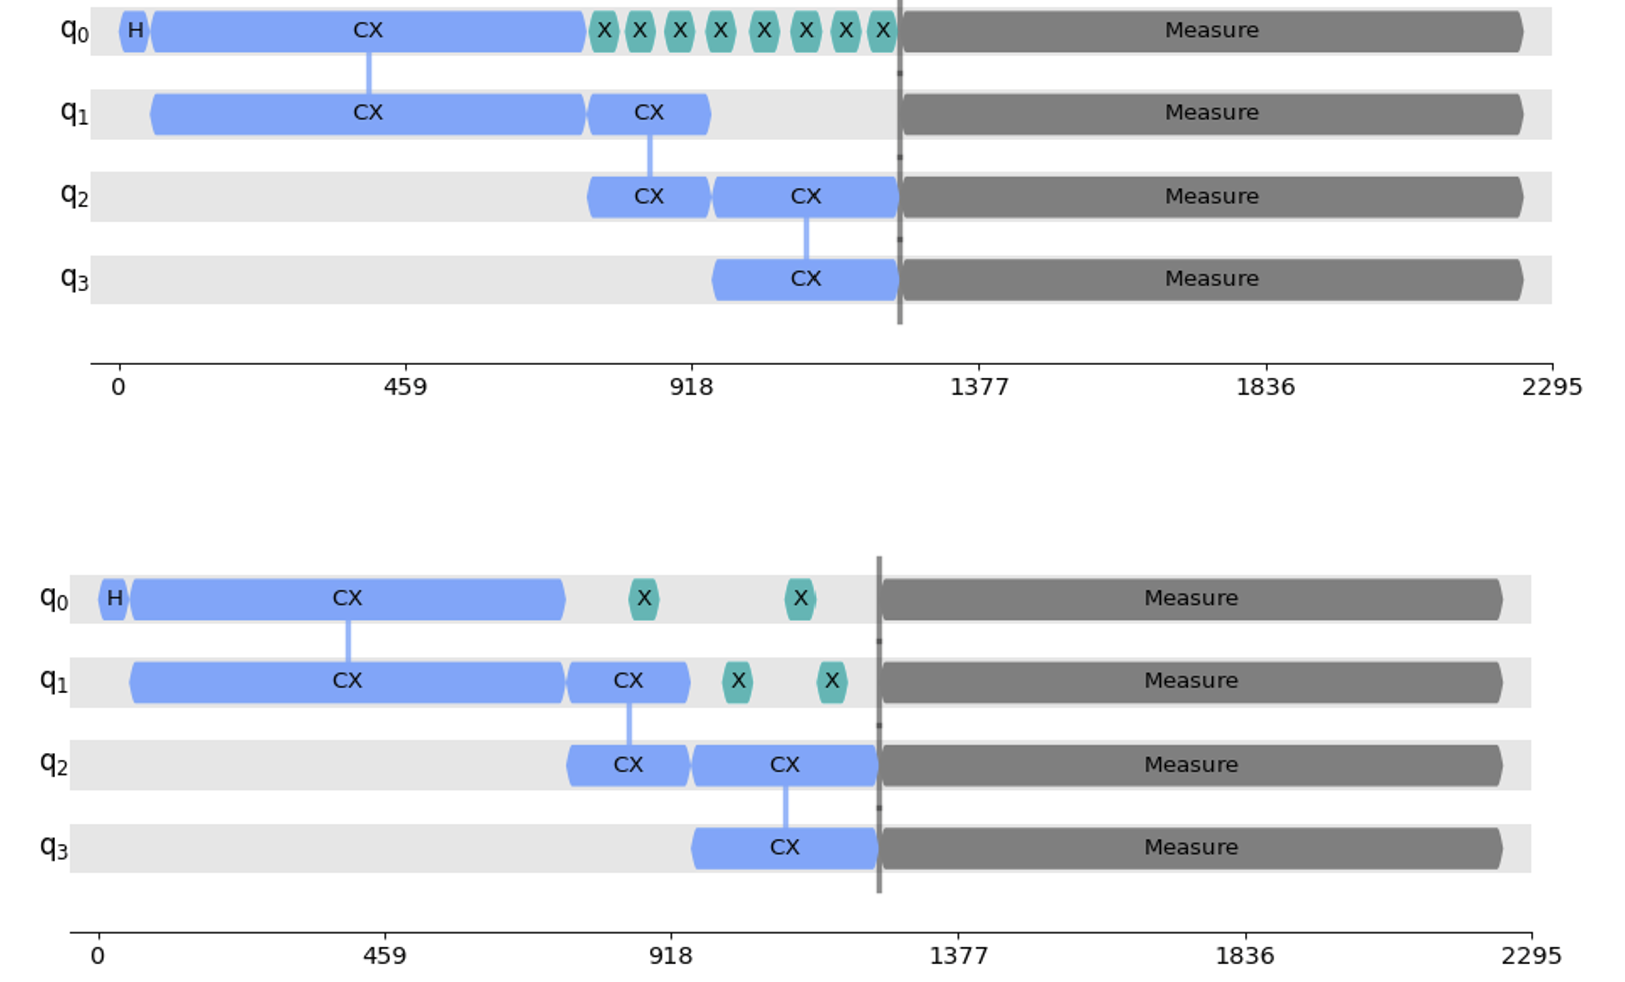


You can find more information about the dynamical decoupling [here](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager).


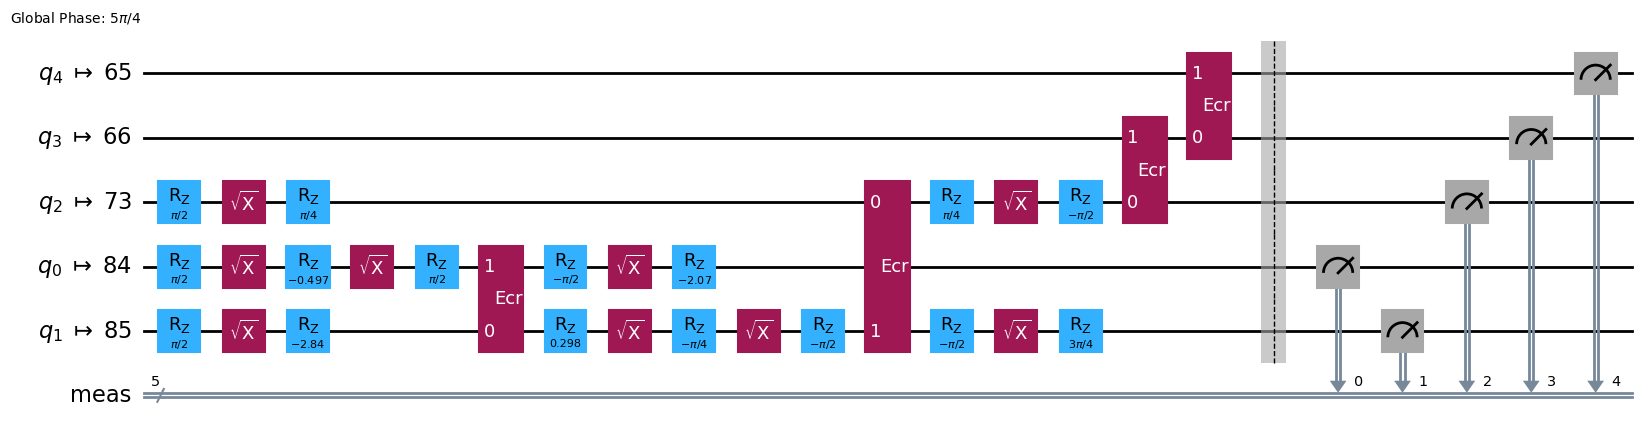

In [56]:

circ = QuantumCircuit(5)
circ.h(0)
circ.ecr(0, 1)
circ.ecr(1, 2)
circ.ecr(2, 3)
circ.ecr(3, 4)
circ.measure_all()

#transpiled_qasm, initial_mapping = q.compile(qasm=dumps(circ), compilation_name="qiskit_3")
#transpiled_circ = QuantumCircuit.from_qasm_str(transpiled_qasm)
target = noisy_simulator.target
basis_gates = list(target.operation_names)

pm = generate_preset_pass_manager(3, target=target, seed_transpiler=12345)
transpiled_circ = pm.run(circ)

transpiled_circ.draw("mpl", idle_wires=False, fold=60)

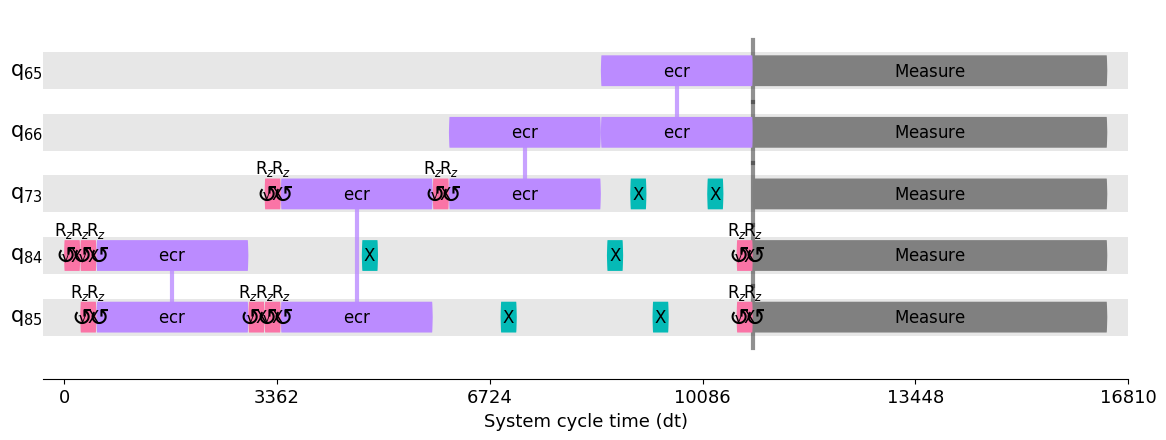

In [41]:
circuit_dd = apply_dd(noisy_simulator, transpiled_circ)
timeline_drawer(circuit_dd, show_idle=False)


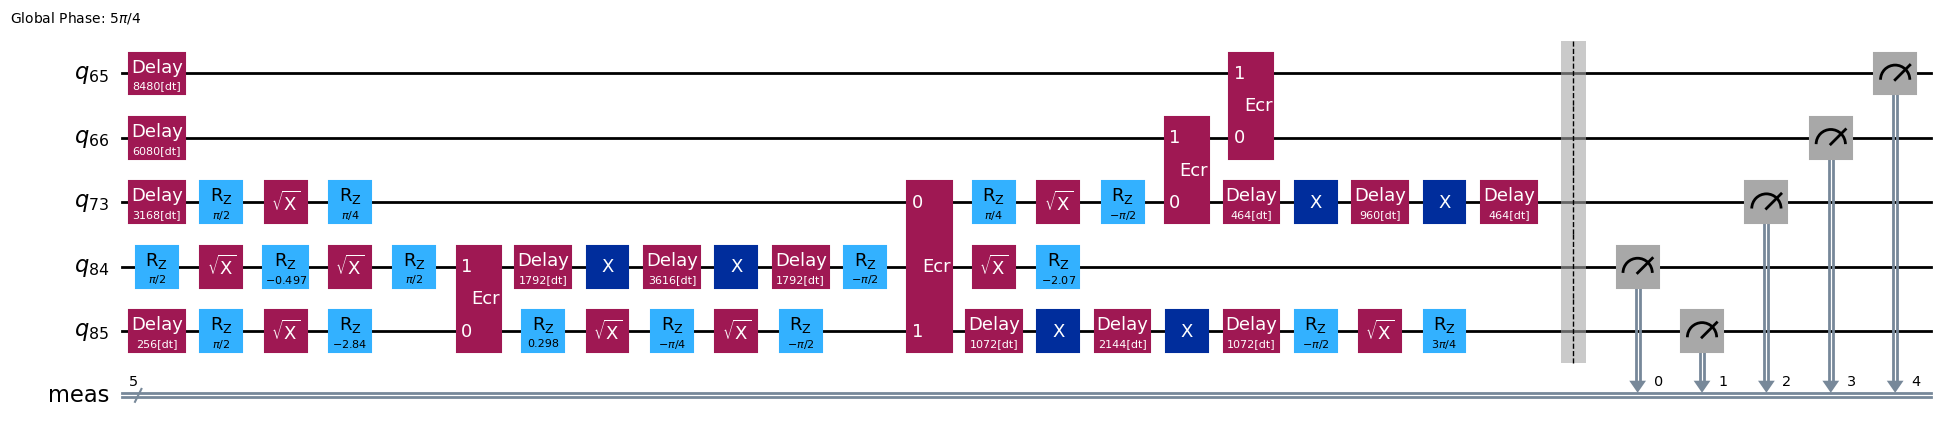

In [42]:
circuit_dd.draw("mpl", idle_wires=False, fold=60)

In [43]:
job = noisy_simulator.run(circuit_dd, shots=10000)
result = job.result()  
output = result.get_counts()
output_normalize = normalize_counts(output, shots=shots)
output

{'00100': 3,
 '11110': 2,
 '00111': 2,
 '10100': 4,
 '11111': 2,
 '01100': 3,
 '00101': 6,
 '10101': 6,
 '10110': 6,
 '11101': 2,
 '00110': 3,
 '00010': 614,
 '10010': 620,
 '01101': 5,
 '10111': 4,
 '01010': 648,
 '01001': 622,
 '11011': 598,
 '10001': 626,
 '01000': 685,
 '11010': 623,
 '00001': 597,
 '00011': 609,
 '01011': 591,
 '11000': 645,
 '01111': 2,
 '01110': 2,
 '10011': 600,
 '11001': 644,
 '10000': 627,
 '00000': 599}

In [ ]:
circ_dd.draw("mpl")

In [57]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions, SamplerOptions
)

In [62]:
## DD
options = SamplerOptions(
    default_shots=5000,
    dynamical_decoupling={
        'enable':True, 
        'sequence_type':'XpXm', 
        'extra_slack_distribution':'middle',
        'scheduling_method':'alap'},
    execution={
        'init_qubits':True,
         #'rep_delay':
    },
    twirling={
        'enable_gates': False, 
        'enable_measure': True,
        'num_randomizations':'auto',
        'shots_per_randomization':'auto',
        'strategy':'all'
    }
) 

In [65]:
sampler = Sampler(mode=backend_service, options=options)

In [67]:
qasm = QiskitCircuit(dumps(circ))
compiled_circuit = qasm.transpile_to_target_backend(q.backend)

In [68]:
sampler.run([compiled_circuit])

<RuntimeJobV2('csqys5cvwqp0008btkeg', 'sampler')>

### Zero Noise Extrapolation (ZNE)

In [ ]:
durations = InstructionDurations.from_backend(backend_service)


In [ ]:
durations.get('id', (3,))

In [ ]:
durations.duration_by_name_qubits[('id', (0, ))][1]